# Exploratory Data Analysis

## Libraries and data import

In [ ]:
!pip install -q networkx
!pip install -q mlflow
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q git+https://github.com/rusty1s/pytorch_geometric.git

In [ ]:
import os, sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import plotly.express as px
import plotly.io as pio
pio.templates.default = 'seaborn'

sys.path.append(os.path.abspath('..'))

In [ ]:
from src.utils import FILES, extract_study_phase

CONNECTION_DIR = '/datasets/'
DATA_FOLDERS = ['data2021-09-20', 'data2021-10-04']

## Lesions

### Dataset information

The lesions dataset contains the following features:

* Each patient is attributed to a unique `gpcr_id [int]` 
* Each study is identified relative to the start of treatment with `study_name [str]` and the processed `study_phase [int]`
* `roi_id [int]` is an identifier for the lesion's ROI (Region Of Interest)
* `roi_name [str]` is a textual identifier for the lesion
* `lesion_label_id [int]` is an identifier for the lesion's label
* `pars_bodypart_petct [str]`, `pars_region_petct [str]`, `pars_subregion_petct [str]`, `pars_laterality_petct [str]` are categorical values output by PARS that help identify the location of the lesion
* `pars_classification_petct [str]` is a categorical variable (either `benign` or `suspicious`)
* `vol_ccm [float]` is the lesion volume in cubic centimeters
* `max_suv_val [float]`, `mean_suv_val [float]`, `min_suv_val [float]`, and `sd_suv_val [float]` are relative to the lesions [SUV  (Standardized Uptake Values)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3026294/)
* `is_malignant [bool]` is the boolean value of `pars_classification_petct == 'suspicious'`
*  `assigned_organ [str]` is the lesion's assigned organ (which is PARS output)

### Preprocessing

In [ ]:
lesions = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[0], FILES['lesions']))
lesions['study_phase'] = lesions.study_name.apply(extract_study_phase)
lesions = lesions[lesions.pars_classification_petct != 'benign']

# Sorting by PARS classification allows for visualization consistency
lesions.sort_values(by='pars_classification_petct', inplace=True)
n_lesions, f_lesions = lesions.shape

print(f'Imported {n_lesions} lesions with {f_lesions} features. Null values: {lesions.isna().sum().sum()}')

Imported 3251 lesions with 18 features. Null values: 0


In [ ]:
lesions

,gpcr_id,study_name,roi_id,roi_name,lesion_label_id,pars_bodypart_petct,pars_region_petct,pars_subregion_petct,pars_laterality_petct,pars_classification_petct,vol_ccm,max_suv_val,mean_suv_val,min_suv_val,sd_suv_val,is_malignant,assigned_organ,study_phase
0,34610002,pre-01,0,Muscles1,1,lower limb,muscles,upper leg group,right,suspicious,1.00,5.58,3.37,2.36,0.92,True,other_lowerlimb,-1
16135,34610104,post-01,23,Liver1,24,abdomen,liver,not specified,right,suspicious,1.03,3.66,3.13,2.82,0.21,True,liver,1
16137,34610104,post-01,25,Liver2,26,abdomen,liver,not specified,right,suspicious,2.91,7.23,4.16,3.05,0.98,True,liver,1
16138,34610104,post-01,26,Liver3,27,abdomen,liver,not specified,left,suspicious,3.89,4.41,2.96,2.51,0.43,True,liver,1
16142,34610104,post-01,30,Spleen1,31,abdomen,spleen,not specified,not specified,suspicious,13.54,16.34,10.14,6.87,2.08,True,spleen,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8143,34610044,post-03,49,Bones12,50,thorax,bones,ribs,not specified,suspicious,0.51,3.43,2.35,1.81,0.46,True,other_thorax,3
8144,34610044,post-03,50,Pleura2,51,thorax,pleura,not specified,not specified,suspicious,5.82,11.60,7.23,4.89,1.65,True,other_thorax,3
8145,34610044,post-03,51,LymphNodes11,52,thorax,lymph nodes,IASLC station 10,left,suspicious,0.66,4.59,3.86,3.54,0.30,True,lymphnode_thorax,3
8135,34610044,post-03,39,Bones9,40,thorax,bones,ribs,not specified,suspicious,0.88,4.20,2.60,1.78,0.66,True,bones_thorax,3


In [ ]:
lesions_labels = {
    'vol_ccm': 'Lesion volume (ccm)',
    'pars_classification_petct': 'PARS lesion classification',
    'study_phase': 'Study phase (relative to treatment start)',
    'assigned_organ': 'Assigned organ'
}

In [ ]:
top_h_legend = dict(orientation='h', yanchor="bottom", y=1.02)

### Visualisations

In [ ]:
descending_organs = list(lesions.groupby('assigned_organ').size().sort_values(ascending=False).index)

px.histogram(lesions, x='assigned_organ', color='pars_classification_petct', 
             category_orders={'assigned_organ': descending_organs},
             labels=lesions_labels) \
    .update_layout(legend=top_h_legend, yaxis_title='Lesions')

In [ ]:
progression = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1], FILES['progression']))
progression['study_phase'] = progression.study_name.apply(extract_study_phase)

In [ ]:
avg_lesion_vol_w_na = lesions.groupby(['gpcr_id', 'study_phase']) \
    .vol_ccm.mean().to_frame('vol_ccm').reset_index() \
    .merge(progression[['gpcr_id', 'prediction_score', 'study_phase']],
           on=['gpcr_id', 'study_phase'], how='inner')
    
avg_lesion_vol = avg_lesion_vol_w_na.dropna()

print(f'All studies with progression: {progression.shape[0]} \n'
      f'Aggregated lesions per study from lesions df: {avg_lesion_vol_w_na.shape[0]} \n'
      f'Inner merge with dropped NA progression values: {avg_lesion_vol.shape[0]}')

px.box(avg_lesion_vol, x='study_phase', y='vol_ccm', color='prediction_score', 
       labels={**lesions_labels,
               'vol_ccm': 'Average lesion volume (ccm)',
               'prediction_score': 'Response'}) \
    .update_layout(legend=top_h_legend)

All studies with progression: 531 
Aggregated lesions per study from lesions df: 366 
Inner merge with dropped NA progression values: 331


In [ ]:
location_hierarchy = ['pars_bodypart_petct', 'pars_region_petct', 'pars_subregion_petct']
locations = lesions.groupby(location_hierarchy).size().to_frame('lesions').reset_index()

px.sunburst(locations, path=location_hierarchy, values='lesions') \
    .update_layout(title='Sunburst chart of lesion location')

## Studies

### Dataset information

* Each patient is attributed to a unique `gpcr_id [int]` 
* Each study is identified relative to the start of treatment with `study_name [str]` and the processed `study_phase [int]`
* `is_before_treatment [bool]`, `is_during_treatment [bool]`, and `is_after_treatment_end [bool]` are boolean values that explain when the study occured relative to treatment start and end
* `nth_before_treatment [float]`, `nth_after_treatment_start [float]`, `nth_during_treatment [float]`, and `nth_after_treatment_end [float]` is the scan number relative to treatment start and end
* `n_days_to_treatment_start [int]` and `n_days_to_treatment_end [int]` are the number of days to treatment start and end
* `is_malignant [int]` is the aggregate number of malignant lesions in the exam, which is renamed to `malignant_lesions [int]` during preprocessing
* Boolean values about segmentation existance are contained in `brain_seg_exists [bool]`, `bones_seg_exists [bool]`, `spleen_seg_exists [bool]`, `aorta_seg_exists [bool]`, `heart_seg_exists [bool]`, `kidney_right_seg_exists [bool]`, `kidney_left_seg_exists [bool]`, `lung_right_seg_exists [bool]`, `lung_left_seg_exists [bool]`, and `liver_seg_exists [bool]`

### Preprocessing

In [ ]:
studies = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[0], FILES['studies']))
studies.rename(columns={'is_malignant': 'malignant_lesions'}, inplace=True)
studies = studies.merge(progression, on=['gpcr_id', 'study_name'], how='inner')

n_studies, f_studies = studies.shape

print(f'Imported {n_studies} studies with {f_studies} features. Null values: {studies.isna().sum().sum()}')

Imported 472 studies with 27 features. Null values: 1308


In [ ]:
studies

,gpcr_id,study_name,is_before_treatment,is_during_treatment,is_after_treatment_end,nth_before_treatment,nth_after_treatment_start,nth_during_treatment,nth_after_treatment_end,n_days_to_treatment_start_x,...,kidney_right_seg_exists,kidney_left_seg_exists,lung_right_seg_exists,lung_left_seg_exists,liver_seg_exists,n_days_to_treatment_start_y,n_days_to_treatment_end_y,prediction_score,pseudorecist,study_phase
0,34610001,pre-02,True,False,False,2.0,NaN,NaN,NaN,-43,...,True,True,True,True,True,-43.0,-106.0,PD,NaN,-2
1,34610001,pre-01,True,False,False,1.0,NaN,NaN,NaN,-7,...,True,True,True,True,True,-7.0,-70.0,PD,NaN,-1
2,34610001,post-01,False,False,True,NaN,1.0,NaN,1.0,87,...,True,True,True,True,True,87.0,24.0,NPD,NaN,1
3,34610001,post-02,False,False,True,NaN,2.0,NaN,2.0,183,...,False,False,True,True,True,183.0,120.0,NaN,NaN,2
4,34610001,post-03,False,False,True,NaN,3.0,NaN,3.0,275,...,True,True,True,True,True,275.0,212.0,NaN,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,34610149,post-02,False,False,True,NaN,2.0,NaN,2.0,136,...,True,True,True,True,True,136.0,70.0,NaN,NaN,2
468,34610150,post-01,False,False,True,NaN,1.0,NaN,1.0,63,...,True,True,True,True,True,63.0,42.0,NaN,NaN,1
469,34610150,post-02,False,False,True,NaN,2.0,NaN,2.0,147,...,True,True,True,True,True,147.0,126.0,NPD,NPD,2
470,34610150,post-03,False,False,True,NaN,3.0,NaN,3.0,247,...,True,True,True,True,True,247.0,226.0,NaN,NaN,3


In [ ]:
studies_labels = {
    **lesions_labels,
    'prediction_score': 'Immunotherapeutic response',
    'response': 'TMTV response',
    'tmtv': 'Total Metabolic Tumor Volume (ccm)',
    'baseline': 'Baseline TMTV (ccm)'
}

#### Creating temporary labels using TMTV (Total Metabolic Tumor Volume)


* If TMTV is non-zero, but lower compared to baseline: Partial response
* If TMTV is zero / no lesions detected: Complete response
* If TMTV > 'best' previous response: progressive disease.
     'Best' previous responds means minimum TMTV in previous time points
* Otherwise: stable disease

In [ ]:
def classify_response(row):
    # Compare current vs. baseline
    if row.tmtv < row.baseline:
        return 'NPD'
    elif row.tmtv == row.baseline:
        return np.nan
    else:
        return 'PD'

In [ ]:
# Compute TMTV by summing `vol_ccm` per study
labels = lesions.groupby(['gpcr_id', 'study_phase']).vol_ccm.sum().to_frame('tmtv').reset_index()

# Find `labels` id of each patient's baseline TMTV
baseline_idx = labels.groupby('gpcr_id').study_phase.idxmin().to_dict()
labels['baseline'] = labels.gpcr_id.apply(
    lambda i: labels.loc[baseline_idx[i]].tmtv)
labels['response'] = labels.apply(classify_response, axis=1)

print(f'Response computed for {labels.shape[0]} studies: \n{labels.response.value_counts()}')

Response computed for 366 studies: 
PD     124
NPD    123
Name: response, dtype: int64


In [ ]:
labels = labels.merge(progression[['gpcr_id', 'study_phase', 'prediction_score', 'pseudorecist']],
             on=['gpcr_id', 'study_phase'], how='inner')

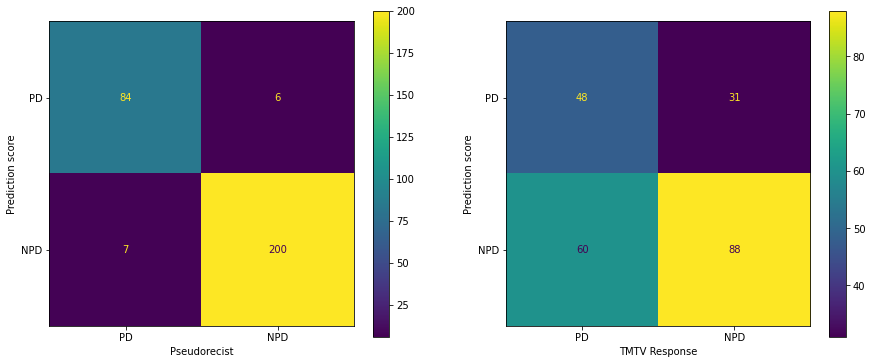

In [ ]:
fig, ax = plt.subplots(1, 2)

cm = confusion_matrix(progression[['prediction_score', 'pseudorecist']].dropna().prediction_score, 
                      progression[['prediction_score', 'pseudorecist']].dropna().pseudorecist,
                      labels=['PD', 'NPD'])

CM = ConfusionMatrixDisplay(cm, display_labels=['PD', 'NPD']).plot(ax=ax[0])

ax[0].set_xlabel('Pseudorecist'), ax[0].set_ylabel('Prediction score')


cm = confusion_matrix(labels[['prediction_score', 'response']].dropna().prediction_score, 
                      labels[['prediction_score', 'response']].dropna().response,
                      labels=['PD', 'NPD'])

CM = ConfusionMatrixDisplay(cm, display_labels=['PD', 'NPD']).plot(ax=ax[1])

ax[1].set_xlabel('TMTV Response'), ax[1].set_ylabel('Prediction score')

plt.gcf().set_size_inches(15, 6)
plt.show()

### Visualisations

In [ ]:
labels

,gpcr_id,study_phase,tmtv,baseline,response,prediction_score,pseudorecist
0,34610002,-1,36.38,36.38,NaN,PD,PD
1,34610002,1,255.99,36.38,PD,PD,PD
2,34610004,-2,16.15,16.15,NaN,PD,NaN
3,34610004,-1,16.73,16.15,PD,PD,NaN
4,34610004,1,23.05,16.15,PD,NPD,NPD
...,...,...,...,...,...,...,...
361,34610148,2,555.24,35.91,PD,NPD,NaN
362,34610148,3,1.15,35.91,NPD,NPD,NPD
363,34610149,-1,3.03,3.03,NaN,PD,NaN
364,34610149,1,26.36,3.03,PD,NaN,NaN


In [ ]:
px.scatter(labels[labels['prediction_score'].notna()], x='study_phase', y='tmtv', color='prediction_score',
           labels=studies_labels) \
    .update_layout(legend=top_h_legend)

In [ ]:
# Checking post-1 label imbalance
post_1_response = labels[labels.study_phase == 1].prediction_score.value_counts()

print(f'Response imbalance for post-1 studies: \n{post_1_response}')

Response imbalance for post-1 studies: 
PD     43
NPD    42
Name: prediction_score, dtype: int64


In [ ]:
px.histogram(labels[(labels.study_phase == 1) & (labels['prediction_score'].notna())], 
             x='tmtv', color='prediction_score',
             nbins= 40, marginal="rug",
             labels=studies_labels) \
    .update_layout(legend={**top_h_legend, 'y': 1.0},
                   yaxis_title='Studies (count)',
                   title='Post-1 study phase response distribution') \
    .update_traces(opacity=0.7)

## Patients

### Dataset information

### Preprocessing

In [ ]:
patients = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[0], FILES['patients']))

patients['age_at_treatment_start_in_years'] = \
    patients.age_at_treatment_start_in_years.apply(
        lambda a: 90 if a == '90 or older' else int(a))

patients['survival_1_year'] = (patients.survival_in_days > 365)

blood = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[1], FILES['blood']))
blood.drop(columns=['n_days_to_treatment_start', 'n_days_to_treatment_end'], inplace=True)
blood.rename(columns={feature: feature.replace('-', '_') for feature in blood.columns}, inplace=True)

patients = patients.merge(blood, on='gpcr_id', how='inner')

n_patients, f_patients = patients.shape

print(f'Imported {n_patients} patients with {f_studies} features. Null values: {patients.isna().sum().sum()}')

Imported 129 patients with 27 features. Null values: 1311


In [ ]:
patients

,gpcr_id,age_at_treatment_start_in_years,duration_treatment_in_days,death_event_observed,survival_in_days,n_imgs_before_treatment,n_imgs_during_treatment,n_imgs_after_treatment_end,n_imgs_after_treatment_start,survival_1_year,...,NRAS_MUTATION,NRAS_MUT_TYPE,BRAF_MUTATION,BRAF_MUT_TYPE,concomittant_tvec,concomittant_LAG3,prior_targeted_therapy,prior_treatment,immuno_therapy_type,nivo_maintenance
0,34610039,64,63,False,768,1,0,1,1,True,...,NaN,NaN,y,V600E,0,0,0,0,ipinivo,1
1,34610116,80,22,False,1312,2,0,4,4,True,...,NaN,NaN,n,NaN,0,0,0,0,ipinivo,0
2,34610117,55,0,False,1145,0,0,4,4,True,...,n,NaN,y,V600E,0,0,0,0,ipinivo,0
3,34610118,68,63,True,639,2,0,6,6,True,...,n,NaN,n,NaN,0,0,0,0,ipinivo,1
4,34610042,52,60,False,707,0,0,7,7,True,...,n,NaN,y,G464R,0,0,0,0,ipinivo,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,34610037,88,261,True,747,1,2,3,5,True,...,n,NaN,n,NaN,0,0,0,0,nivo,0
125,34610114,77,21,False,1343,1,0,4,4,True,...,n,NaN,n,NaN,0,0,0,0,ipinivo,0
126,34610005,51,63,False,1619,0,0,10,10,True,...,n,NaN,y,V600E,0,0,0,0,ipinivo,1
127,34610115,71,0,False,1690,0,0,3,3,True,...,n,NaN,y,V600K,0,0,0,0,ipinivo,0


In [ ]:
patients_labels = {
    **studies_labels,
    'age_at_treatment_start_in_years': 'Age (treatment start, years)',
    'duration_treatment_in_days': 'Treatment duration (days)',
    'death_event_observed': 'Death observed',
    'survival_in_days': 'Survival time (days)',
    'time': 'Time (days)',
    'survival_probability': 'Survival probability',
    'survival_1_year': '1-year Survival',
    'bmi': 'Body-Mass Index',
    'sex': 'Sex'
}

### Visualisations

In [ ]:
px.histogram(patients, x='age_at_treatment_start_in_years', color='survival_1_year',
             labels=patients_labels) \
    .update_layout(legend=top_h_legend, yaxis_title='Patients (count)', barmode='overlay') \
    .update_traces(opacity=0.5)

In [ ]:
px.histogram(patients, x='duration_treatment_in_days', facet_col='survival_1_year',
             labels=patients_labels) \
    .update_layout(legend=top_h_legend, yaxis_title='Patients (count)')

In [ ]:
px.scatter(patients, x='age_at_treatment_start_in_years', 
           y='survival_in_days', color='survival_1_year',
           labels=patients_labels) \
    .update_layout(legend=top_h_legend)

In [ ]:
!pip install -q scikit-survival
from sksurv.nonparametric import kaplan_meier_estimator

# Kaplan-Meier
time, s_prob = kaplan_meier_estimator(patients.death_event_observed, patients.survival_in_days)
km_df = pd.DataFrame(np.array([time, s_prob]).T, columns=['time', 'survival_probability'])

ContextualVersionConflict: (scikit-learn 1.0 (/shared-libs/python3.7/py/lib/python3.7/site-packages), Requirement.parse('scikit-learn<0.25,>=0.24.0'), {'scikit-survival'})

In [ ]:
px.line(km_df, x='time', y='survival_probability', line_shape='hv',
        labels=patients_labels)

In [ ]:
px.scatter(patients, x='bmi', y='age_at_treatment_start_in_years', color='sex',
           labels=patients_labels) \
    .update_layout(legend=top_h_legend)

In [ ]:
px.scatter_matrix(patients, 
                  dimensions=['asat_sang_ul', 'bili_totale_sang_umoll', 'mono_absolus_gl',
       'alat_sang_ul', 'plaquettes_sang_gl', 'lympho_absolus_gl',
       'albumine_sang_gl', 'proteine_c_reacsang_mgl', 'potassium_sang_mmoll',
       'hemoglobine_sang_gl']) \
    .update_layout(legend=top_h_legend)

In [ ]:
px.scatter_matrix(patients, 
                  dimensions=['calcium_sang_mmoll', 'ldh_sang_ul',
       'creatinine_sang_umoll', 'pal_sang_ul', 'neutro_absolus_gl',
       'eosini_absolus_gl', 'baso_absolus_gl', 'ggt_sang_ul',
       'gfr_cal_mlmin173m2', 'leucocytes_sang_gl']) \
    .update_layout(legend=top_h_legend)

In [ ]:
px.scatter_matrix(patients, 
                  dimensions=['eGFRCKD2', 'eGFRCG', 'X67',
       'NRAS_MUTATION', 'NRAS_MUT_TYPE', 'BRAF_MUTATION', 'BRAF_MUT_TYPE',
       'concomittant_tvec', 'concomittant_LAG3', 'prior_targeted_therapy',
       'prior_treatment', 'immuno_therapy_type', 'nivo_maintenance']) \
    .update_layout(legend=top_h_legend)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7360151b-146e-499a-b01b-835ca18c34fa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>